# Naive Bayes and logistic regression

In [1]:
# Package Imports
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import datasets, model_selection
%matplotlib inline

#### The Iris dataset


For this analysis, I will be using the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html). It consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters.

Reference:
- R. A. Fisher. "The use of multiple measurements in taxonomic problems". Annals of Eugenics. 7 (2): 179–188, 1936.

I will be using a Naive Bayes classifier model that predicts the correct class from the sepal length and sepal width features. And then compare it to logistic regression.

#### Load and prepare the data

In [2]:
# Load the dataset

iris = datasets.load_iris()

In [3]:
# Looking only at the first two features: sepal length and width

data = iris.data[:, :2]
targets = iris.target

In [4]:
# Randomly shuffle the data and make train and test splits

x_train, x_test, y_train, y_test = model_selection.train_test_split(data, targets, test_size=0.2)

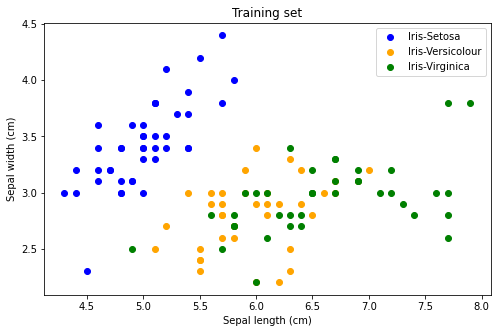

In [5]:
# Plot the training data

labels = {0: 'Iris-Setosa', 1: 'Iris-Versicolour', 2: 'Iris-Virginica'}
label_colours = ['blue', 'orange', 'green']

def plot_data(x, y, labels, colours):
    for c in np.unique(y):
        inx = np.where(y == c)
        plt.scatter(x[inx, 0], x[inx, 1], label=labels[c], c=colours[c])
    plt.title("Training set")
    plt.xlabel("Sepal length (cm)")
    plt.ylabel("Sepal width (cm)")
    plt.legend()
    
plt.figure(figsize=(8, 5))
plot_data(x_train, y_train, labels, label_colours)
plt.show()

### Naive Bayes classifier

The fundamental equation for this classifier is Bayes' rule:

$$
P(Y=y_k | X_1,\ldots,X_d) = \frac{P(X_1,\ldots,X_d | Y=y_k)P(Y=y_k)}{\sum_{k=1}^K P(X_1,\ldots,X_d | Y=y_k)P(Y=y_k)}
$$

In the above, $d$ is the number of features or dimensions in the inputs $X$ (in our case $d=2$), and $K$ is the number of classes (in our case $K=3$). The distribution $P(Y)$ is the class prior distribution, which is a discrete distribution over $K$ classes. The distribution $P(X | Y)$ is the class-conditional distribution over inputs.

The Naive Bayes classifier makes the assumption that the data features $X_i$ are conditionally independent give the class $Y$ (the 'naive' assumption). In this case, the class-conditional distribution decomposes as

$$
\begin{align}
P(X | Y=y_k) &= P(X_1,\ldots,X_d | Y=y_k)\\
&= \prod_{i=1}^d P(X_i | Y=y_k)
\end{align}
$$

This simplifying assumption means that we typically need to estimate far fewer parameters for each of the distributions $P(X_i | Y=y_k)$ instead of the full joint distribution $P(X | Y=y_k)$.

Once the class prior distribution and class-conditional densities are estimated, the Naive Bayes classifier model can then make a class prediction $\hat{Y}$ for a new data input $\tilde{X} := (\tilde{X}_1,\ldots,\tilde{X}_d)$ according to

$$
\begin{align}
\hat{Y} &= \text{argmax}_{y_k} P(Y=y_k | \tilde{X}_1,\ldots,\tilde{X}_d) \\
&= \text{argmax}_{y_k}\frac{P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)}{\sum_{k=1}^K P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)}\\
&= \text{argmax}_{y_k} P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)
\end{align}
$$

#### Define the class prior distribution
 
Maximum likelihood estimate:

$$
P(Y=y_k) = \frac{\sum_{n=1}^N \delta(Y^{(n)}=y_k)}{N},
$$

where the superscript $(n)$ indicates the $n$-th dataset example, $\delta(Y^{(n)}=y_k) = 1$ if $Y^{(n)}=y_k$ and 0 otherwise, and $N$ is the total number of examples in the dataset. The above is simply the proportion of data examples belonging to class $k$.

In [6]:
# Function that builds prior distribution from the training dataand returns it as a Categorical Distribution object.

def get_prior(y):
    """
    This function takes training labels as a numpy array y of shape (num_samples,) as an input.
    Your function should 
    This function should build a Categorical Distribution object with empty batch shape 
    and event shape, with the probability of each class given as above. 
    Your function should return the Distribution object.
    """
    prob = tf.divide(tf.math.bincount(y), len(y))
    return tfp.distributions.Categorical(probs=prob)
    
    

In [7]:
prior = get_prior(y_train)

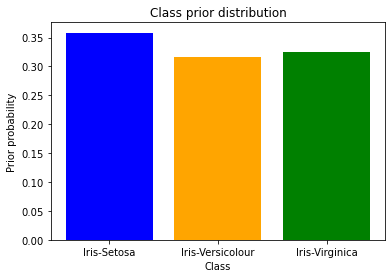

In [8]:
# Plot the prior distribution

labels = ['Iris-Setosa', 'Iris-Versicolour', 'Iris-Virginica']
plt.bar([0, 1, 2], prior.probs.numpy(), color=label_colours)
plt.xlabel("Class")
plt.ylabel("Prior probability")
plt.title("Class prior distribution")
plt.xticks([0, 1, 2], labels)
plt.show()

#### Define the class-conditional densities

Assuming class conditionals to be univariate Gaussian:

$$
\begin{align}
P(X_i | Y=y_k) &= N(X_i | \mu_{ik}, \sigma_{ik})\\
&= \frac{1}{\sqrt{2\pi\sigma_{ik}^2}} \exp\left\{-\frac{1}{2} \left(\frac{x - \mu_{ik}}{\sigma_{ik}}\right)^2\right\}
\end{align}
$$
with mean parameters $\mu_{ik}$ and standard deviation parameters $\sigma_{ik}$, twelve parameters in all. 
Estimate these parameters using maximum likelihood given by

$$
\begin{align}
\hat{\mu}_{ik} &= \frac{\sum_n X_i^{(n)} \delta(Y^{(n)}=y_k)}{\sum_n \delta(Y^{(n)}=y_k)} \\
\hat{\sigma}^2_{ik} &= \frac{\sum_n (X_i^{(n)} - \hat{\mu}_{ik})^2 \delta(Y^{(n)}=y_k)}{\sum_n \delta(Y^{(n)}=y_k)}
\end{align}
$$


In [9]:
# computes the class-conditional Gaussian densities, using the maximum likelihood parameter 
# estimates given above, and returns them in a single, batched MultivariateNormalDiag Distribution object

def get_class_conditionals(x, y):
    """
    This function takes training data samples x and labels y as inputs.
    This function should build the class-conditional Gaussian distributions above. 
    It should construct a batch of distributions for each feature and each class, using the 
    parameter estimates above for the means and standard deviations.
    The batch shape of this distribution should be rank 2, where the first dimension corresponds
    to the number of classes and the second corresponds to the number of features.
    Your function should then return the Distribution object.
    """
    n_classes = y.max()+1
    mu = []
    std = []
    for c_k in range(n_classes):
        class_mask = (y == c_k)
        mu.append(list(x[class_mask, :].mean(axis=0)))
        std.append(list(x[class_mask, :].std(axis=0)))
    distribution = tfp.distributions.MultivariateNormalDiag(loc=mu, scale_diag=std)
    return distribution
    

In [10]:

class_conditionals = get_class_conditionals(x_train, y_train)

In [11]:
class_conditionals

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[3] event_shape=[2] dtype=float64>

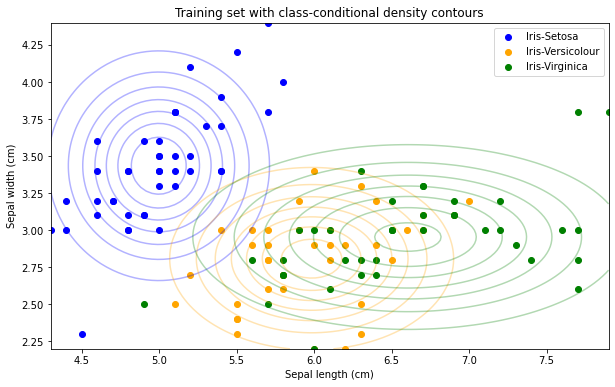

In [12]:
# Plot the training data with the class-conditional density contours

def get_meshgrid(x0_range, x1_range, num_points=100):
    x0 = np.linspace(x0_range[0], x0_range[1], num_points)
    x1 = np.linspace(x1_range[0], x1_range[1], num_points)
    return np.meshgrid(x0, x1)

def contour_plot(x0_range, x1_range, prob_fn, batch_shape, colours, levels=None, num_points=100):
    X0, X1 = get_meshgrid(x0_range, x1_range, num_points=num_points)
    Z = prob_fn(np.expand_dims(np.array([X0.ravel(), X1.ravel()]).T, 1))
    Z = np.array(Z).T.reshape(batch_shape, *X0.shape)
    for batch in np.arange(batch_shape):
        if levels:
            plt.contourf(X0, X1, Z[batch], alpha=0.2, colors=colours, levels=levels)
        else:
            plt.contour(X0, X1, Z[batch], colors=colours[batch], alpha=0.3)

plt.figure(figsize=(10, 6))
plot_data(x_train, y_train, labels, label_colours)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), class_conditionals.prob, 3, label_colours)
plt.title("Training set with class-conditional density contours")
plt.show()

#### Make predictions from the model

Compute the model's class probability predictions for an unknown test input $\tilde{X} = (\tilde{X}_1,\ldots,\tilde{X}_d)$, according to

$$
P(Y=y_k | \tilde{X}_1,\ldots,\tilde{X}_d) = \frac{P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)}{\sum_{k=1}^K P(\tilde{X}_1,\ldots,\tilde{X}_d | Y=y_k)P(Y=y_k)}
$$

The class prediction can then be taken as the class with the maximum probability:

$$
\hat{Y} = \text{argmax}_{y_k} P(Y=y_k | \tilde{X}_1,\ldots,\tilde{X}_d)
$$

You should now write a function to return the model's class probabilities for a given batch of test inputs of shape `(batch_shape, 2)`, where the `batch_shape` has rank at least one. 

* The inputs to the function are the `prior` and `class_conditionals` distributions, and the inputs `x`
* Your function should use these distributions to compute the probabilities for each class $k$ as above
  * As before, your function should work for any number of classes $K\ge 1$
* It should then compute the prediction by taking the class with the highest probability
* The predictions should be returned in a numpy array of shape `(batch_shape)`

In [13]:
# function to return the model's class probabilities for a given batch of test inputs 
# of shape (batch_shape, 2)

def predict_class(prior, class_conditionals, x):
    """
    This function takes the prior distribution, class-conditional distribution, and 
    a batch of inputs in a numpy array of shape (batch_shape, 2).
    This function should compute the class probabilities for each input in the batch, using
    the prior and class-conditional distributions, according to the above equation.
    Note that the batch_shape of x could have rank higher than one!
    Your function should then return the class predictions by taking the class with the 
    maximum probability in a numpy array of shape (batch_shape,).
    """
    y = []
    for k in x:
        cc_prob = class_conditionals.prob(k)
        prob = cc_prob*prior.probs
        y.append(prob.numpy().argmax())
    return np.array(y)
    

In [14]:
predictions = predict_class(prior, class_conditionals, x_test)

In [15]:
# Evaluate the model accuracy on the test set

accuracy = accuracy_score(y_test, predictions)
print("Test accuracy: {:.4f}".format(accuracy))

Test accuracy: 0.7667


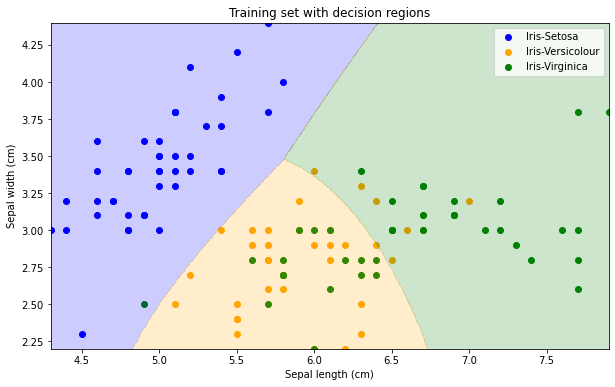

In [16]:
# Plot the model's decision regions

plt.figure(figsize=(10, 6))
plot_data(x_train, y_train, labels, label_colours)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), 
             lambda x: predict_class(prior, class_conditionals, x), 
             1, label_colours, levels=[-0.5, 0.5, 1.5, 2.5],
             num_points=500)
plt.title("Training set with decision regions")
plt.show()

### Binary classifier

Draw a connection between the Naive Bayes classifier and logistic regression.

First, we will update our model to be a binary classifier. In particular, the model will output the probability that a given input data sample belongs to the 'Iris-Setosa' class: $P(Y=y_0 | \tilde{X}_1,\ldots,\tilde{X}_d)$. The remaining two classes will be pooled together with the label $y_1$.

In [17]:
# Redefine the dataset to have binary labels

y_train_binary = np.array(y_train)
y_train_binary[np.where(y_train_binary == 2)] = 1

y_test_binary = np.array(y_test)
y_test_binary[np.where(y_test_binary == 2)] = 1

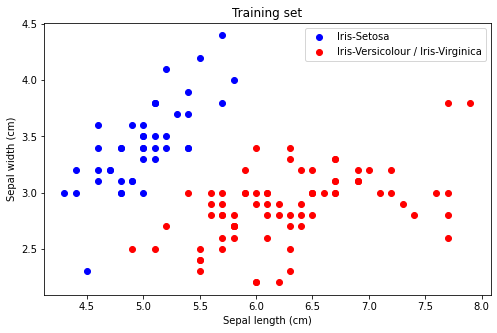

In [18]:
# Plot the training data

labels_binary = {0: 'Iris-Setosa', 1: 'Iris-Versicolour / Iris-Virginica'}
label_colours_binary = ['blue', 'red']

plt.figure(figsize=(8, 5))
plot_data(x_train, y_train_binary, labels_binary, label_colours_binary)
plt.show()

We will also make an extra modelling assumption that for each class $k$, the class-conditional distribution $P(X_i | Y=y_k)$ for each feature $i=0, 1$, has standard deviation $\sigma_i$, which is the same for each class $k$. 

Use maximum likelihood to estimate these parameters. The prior distribution will be as before, with the class prior probabilities given by

$$
P(Y=y_k) = \frac{\sum_{n=1}^N \delta(Y^{(n)}=y_k)}{N},
$$

In [19]:
# Redefine the prior

prior_binary = get_prior(y_train_binary)

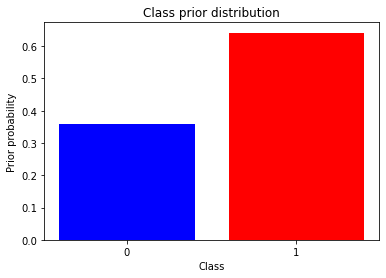

In [20]:
# Plot the prior distribution

plt.bar([0, 1], prior_binary.probs.numpy(), color=label_colours_binary)
plt.xlabel("Class")
plt.ylabel("Prior probability")
plt.title("Class prior distribution")
plt.xticks([0, 1], labels_binary)
plt.show()

For the class-conditional densities, the maximum likelihood estimate for the means are again given by

$$
\hat{\mu}_{ik} = \frac{\sum_n X_i^{(n)} \delta(Y^{(n)}=y_k)}{\sum_n \delta(Y^{(n)}=y_k)} \\
$$

However, the estimate for the standard deviations $\sigma_i$ is updated. There is also a closed-form solution for the shared standard deviations, but we will instead learn these from the data.

You should now write a function that takes the training inputs and target labels as input, as well as an optimizer object, number of epochs and a TensorFlow Variable. This function should be written according to the following spec:

* The inputs to the function are:
  * a numpy array `x` of shape `(num_samples, num_features)` for the data inputs
  * a numpy array `y` of shape `(num_samples,)` for the target labels
  * a `tf.Variable` object `scales` of length 2 for the standard deviations $\sigma_i$
  * `optimiser`: an optimiser object
  * `epochs`: the number of epochs to run the training for
* The function should first compute the means $\mu_{ik}$ of the class-conditional Gaussians according to the above equation
* Then create a batched multivariate Gaussian distribution object using `MultivariateNormalDiag` with the means set to $\mu_{ik}$ and the scales set to `scales`
* Run a custom training loop for `epochs` number of epochs, in which:
  * the average per-example negative log likelihood for the whole dataset is computed as the loss
  * the gradient of the loss with respect to the `scales` variables is computed
  * the `scales` variables are updated by the `optimiser` object
* At each iteration, save the values of the `scales` variable and the loss
* The function should return a tuple of three objects:
   * a numpy array of shape `(epochs,)` of loss values
   * a numpy array of shape `(epochs, 2)` of values for the `scales` variable at each iteration
   * the final learned batched `MultivariateNormalDiag` distribution object
   
_NB: ideally, we would like to constrain the `scales` variable to have positive values. We are not doing that here, but in later weeks of the course you will learn how this can be implemented._

In [21]:
# Function that takes the training inputs and target labels as input, as well as an optimizer
# object, number of epochs and a TensorFlow Variable


def learn_stdevs(x, y, scales, optimiser, epochs):
    """
    This function takes the data inputs, targets, scales variable, optimiser and number of
    epochs as inputs.
    This function should set up and run a custom training loop according to the above 
    specifications, by setting up the class conditional distributions as a MultivariateNormalDiag
    object, and updating the trainable variables (the scales) in a custom training loop.
    Your function should then return the a tuple of three elements: a numpy array of loss values
    during training, a numpy array of scales variables during training, and the final learned
    MultivariateNormalDiag distribution object.
    """

    def nll(x, distribution):
        predictions = -distribution.log_prob(x)
        loss = tf.reduce_sum(predictions[y==0][:,0]) + tf.reduce_sum(predictions[y==1][:,1])
        return loss
    
    @tf.function
    def get_loss_and_grads(x, distribution):
        with tf.GradientTape() as tape:
            tape.watch(distribution.trainable_variables)
            loss = nll(x, distribution)
            grads = tape.gradient(loss, distribution.trainable_variables)
        return loss, grads
    
    n_classes = len(set(y))
    n_feat = x.shape[-1]
    loc = np.zeros([n_classes, n_feat], dtype=np.float32)
    for cls in range(n_classes):
        for feat in range(n_feat):
            data = x[y == cls][:, feat]
            loc[cls, feat] = np.mean(data)
    distribution = tfd.MultivariateNormalDiag(loc=loc, scale_diag=scales)
    x = np.expand_dims(x , 1).astype('float32')
    train_loss_results = []
    train_scale_results = []
    distribution = tfp.distributions.MultivariateNormalDiag(loc=loc, scale_diag=scales)
    for epoch in range(epochs):
        loss, grads = get_loss_and_grads(x, distribution)
        optimiser.apply_gradients(zip(grads, distribution.trainable_variables))
        scale_value = distribution.parameters['scale_diag']
        train_loss_results.append(loss.numpy())
        train_scale_results.append(scale_value.numpy())
    return (np.array(train_loss_results), np.array(train_scale_results), distribution)
    

In [22]:
# Define the inputs to your function

scales = tf.Variable([1., 1.])
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
epochs = 500

In [23]:
# Learn the class-conditional standard deviations

nlls, scales_arr, class_conditionals_binary = learn_stdevs(x_train, y_train_binary, scales, opt, epochs)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [24]:
# View the distribution parameters

print("Class conditional means:")
print(class_conditionals_binary.loc.numpy())
print("\nClass conditional standard deviations:")
print(class_conditionals_binary.stddev().numpy())

Class conditional means:
[[4.9976745 3.4348838]
 [6.2987013 2.8818183]]

Class conditional standard deviations:
[[0.57256466 0.34098163]
 [0.57256466 0.34098163]]


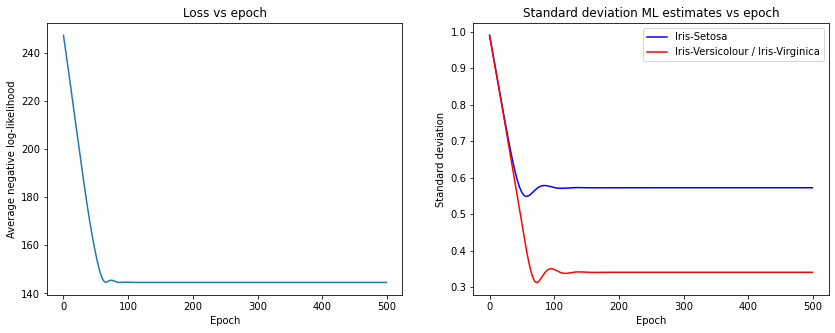

In [25]:
# Plot the loss and convergence of the standard deviation parameters

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(nlls)
ax[0].set_title("Loss vs epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Average negative log-likelihood")
for k in [0, 1]:
    ax[1].plot(scales_arr[:, k], color=label_colours_binary[k], label=labels_binary[k])
ax[1].set_title("Standard deviation ML estimates vs epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Standard deviation")
plt.legend()
plt.show()

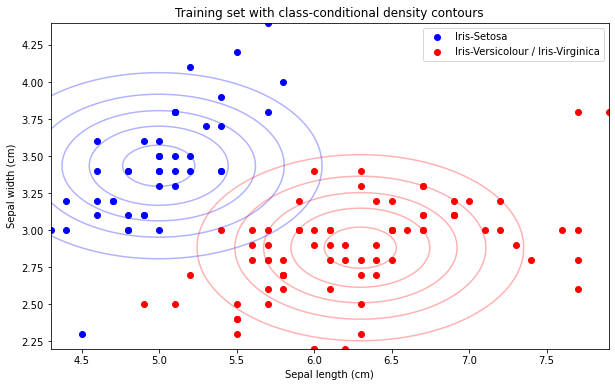

In [26]:
# Plot the training data with the class-conditional density contours

plt.figure(figsize=(10, 6))
plot_data(x_train, y_train_binary, labels_binary, label_colours_binary)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), class_conditionals_binary.prob, 2, label_colours_binary)
plt.title("Training set with class-conditional density contours")
plt.show()

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:Mul]

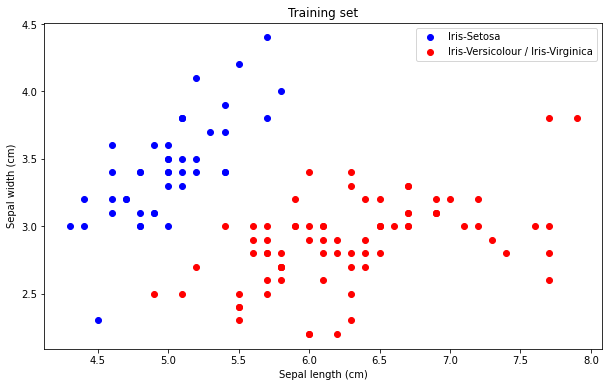

In [27]:
# Plot the model's decision regions

plt.figure(figsize=(10, 6))
plot_data(x_train, y_train_binary, labels_binary, label_colours_binary)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
contour_plot((x0_min, x0_max), (x1_min, x1_max), 
             lambda x: predict_class(prior_binary, class_conditionals_binary, x), 
             1, label_colours_binary, levels=[-0.5, 0.5, 1.5],
             num_points=500)
plt.title("Training set with decision regions")
plt.show()

#### Link to logistic regression

Predictive distribution $P(Y=y_0 | X)$ can be written as follows:


$$
\begin{align}
P(Y=y_0 | X) =& ~\frac{P(X | Y=y_0)P(Y=y_0)}{P(X | Y=y_0)P(Y=y_0) + P(X | Y=y_1)P(Y=y_1)}\\
=&  ~\frac{1}{1 + \frac{P(X | Y=y_1)P(Y=y_1)}{P(X | Y=y_0)P(Y=y_0)}}\\
=& ~\sigma(a)
\end{align}
$$

where $\sigma(a) = \frac{1}{1 + e^{-a}}$ is the sigmoid function, and $a = \log\frac{P(X | Y=y_0)P(Y=y_0)}{P(X | Y=y_1)P(Y=y_1)}$ is the _log-odds_.

With our additional modelling assumption of a shared covariance matrix $\Sigma$, it can be shown (using the Gaussian pdf) that $a$ is in fact a linear function of $X$: 

$$
a = w^T X + w_0
$$

where

$$
\begin{align}
w =& ~\Sigma^{-1} (\mu_0 - \mu_1)\\
w_0 =& -\frac{1}{2}\mu_0^T \Sigma^{-1}\mu_0 + \frac{1}{2}\mu_1^T\Sigma^{-1}\mu_1 + \log\frac{P(Y=y_0)}{P(Y=y_1)}
\end{align}
$$

The model therefore takes the form $P(Y=y_0 | X) = \sigma(w^T X + w_0)$, with weights $w\in\mathbb{R}^2$ and bias $w_0\in\mathbb{R}$. This is the form used by logistic regression, and explains why the decision boundary above is linear. 


In [ ]:
# Get logistic regression parameters w, w0

def get_logistic_regression_params(prior, class_conditionals):
    """
    This function takes the prior distribution and class-conditional distribution as inputs.
    This function should compute the weights and bias terms of the generative logistic
    regression model as above, and return them in a 2-tuple of numpy arrays of shapes
    (2,) and () respectively.
    """
    means = class_conditionals.mean()
    mu0 = means[0]
    mu1 = means[1]
    cov = class_conditionals.covariance()
    covi = tf.linalg.inv(cov)
    priors = prior.probs
    w = np.dot(covi,(mu0-mu1))
    w0 = -(1/2)*np.dot(np.dot(tf.transpose(mu0), covi), mu0) + (1/2)*np.dot(np.dot(tf.transpose(mu1), covi), mu1) + tf.math.log(priors[0]/priors[1])
    return (w, w0.numpy())
    

In [ ]:
w, w0 = get_logistic_regression_params(prior_binary, class_conditionals_binary)

In [ ]:
# Plot the training data with the logistic regression prediction contours

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_data(x_train, y_train_binary, labels_binary, label_colours_binary)
x0_min, x0_max = x_train[:, 0].min(), x_train[:, 0].max()
x1_min, x1_max = x_train[:, 1].min(), x_train[:, 1].max()
X0, X1 = get_meshgrid((x0_min, x0_max), (x1_min, x1_max))

logits = np.dot(np.array([X0.ravel(), X1.ravel()]).T, w) + w0
Z = tf.math.sigmoid(logits)
lr_contour = ax.contour(X0, X1, np.array(Z).T.reshape(*X0.shape), levels=10)
ax.clabel(lr_contour, inline=True, fontsize=10)
contour_plot((x0_min, x0_max), (x1_min, x1_max), 
             lambda x: predict_class(prior_binary, class_conditionals_binary, x), 
             1, label_colours_binary, levels=[-0.5, 0.5, 1.5],
             num_points=300)
plt.title("Training set with prediction contours")
plt.show()